# class 11 - Tree-based Methods

- [11.1 Review: Regression Trees](#11.1-Review:-Regression-Trees)
- [11.2 Bagging](#11.2-Bagging)
- [11.3 Random Forests](#11.3-Random-Forests)
- [11.4 Boosting](#11.4-Boosting)

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pydot
from IPython.display import Image

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

from sklearn import tree
import graphviz

%matplotlib inline
plt.style.use('seaborn-white')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Good explanations and examples at

https://scikit-learn.org/stable/modules/tree.html


### 11.1 Review: Regression Trees

Boston data from R

In [24]:
boston_df = pd.read_csv('../data/Boston.csv')
boston_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
X = boston_df.drop('medv', axis=1)
y = boston_df.medv

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [5]:
# Pruning not supported. Choosing max depth 3)
regr2 = DecisionTreeRegressor(max_depth=3)
regr2.fit(X_train, y_train)
pred = regr2.predict(X_test)

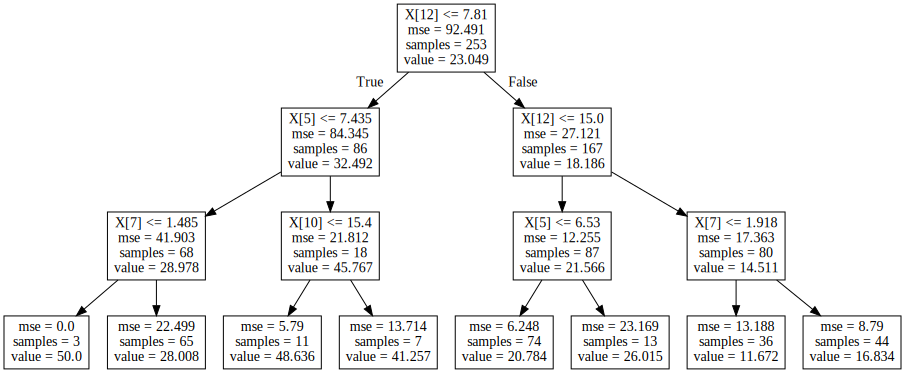

In [6]:
dot_data = tree.export_graphviz(regr2, out_file=None)  
graph = graphviz.Source(dot_data)  
graph 

Text(0,0.5,'y_test')

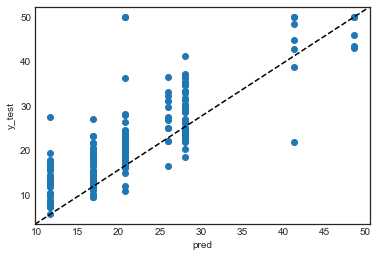

In [7]:
plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

In [11]:
mean_squared_error(y_test, pred)

26.023230850097445

- Remember that the number of samples required to populate the tree doubles for each additional level the tree grows to. Use `max_depth` to control the size of the tree to prevent overfitting.
- Use `min_samples_split` or `min_samples_leaf` to ensure that multiple samples inform every decision in the tree, by controlling which splits will be considered. A very small number will usually mean the tree will overfit, whereas a large number will prevent the tree from learning the data. Try `min_samples_leaf=5` as an initial value. If the sample size varies greatly, a float number can be used as percentage in these two parameters. While min_samples_split can create arbitrarily small leaves, `min_samples_leaf` guarantees that each leaf has a minimum size, avoiding low-variance, over-fit leaf nodes in regression problems. 
- **min_impurity_decrease** : float, optional (default=0.)

    A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

The weighted impurity decrease equation is the following:
$$
    N_t / N * (impurity - N_t_R / N_t * right_impurity
                        - N_t_L / N_t * left_impurity)
$$
where N is the total number of samples, N_t is the number of samples at the current node, N_t_L is the number of samples in the left child, and N_t_R is the number of samples in the right child.

N, N_t, N_t_R and N_t_L all refer to the weighted sum, if sample_weight is passed.

### Purity

![Purity Measures](figures/ESL-Fig9.3.pdf)

### Pruning


![Pruning](figures/ISLR-Fig8.6.pdf)


### Missing Values, Surrogate Variables

Suppose our data has some missing predictor values in some or all of the
variables. We might discard any observation with some missing values, but
this could lead to serious depletion of the training set. Alternatively we
might try to fill in (impute) the missing values, with say the mean of that
predictor over the nonmissing observations. 

For tree-based models, there
are two better approaches. The first is applicable to categorical predictors:
we simply make a new category for “missing.” From this we might discover
that observations with missing values for some measurement behave
differently than those with nonmissing values. 

The second more general
approach is the construction of **surrogate variables**. When considering a
predictor for a split, we use only the observations for which that predictor
is not missing. Having chosen the best (primary) predictor and split point,
we form a list of surrogate predictors and split points. The first surrogate
is the predictor and corresponding split point that best mimics the split of
the training data achieved by the primary split. The second surrogate is
the predictor and corresponding split point that does second best, and so
on. When sending observations down the tree either in the training phase
or during prediction, we use the surrogate splits in order, if the primary
splitting predictor is missing. 

Surrogate splits exploit correlations between
predictors to try and alleviate the effect of missing data. The higher the correlation
between the missing predictor and the other predictors, the smaller
the loss of information due to the missing value.

### h2o library



In [31]:
import h2o
from h2o.estimators import H2ORandomForestEstimator

h2o.init()

# Load data from CSV
data = h2o.import_file('../data/Heart.csv')

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 min 29 secs
H2O cluster timezone:,Europe/Berlin
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.1
H2O cluster version age:,18 days
H2O cluster name:,H2O_from_python_loecherm_dmrps1
H2O cluster total nodes:,1
H2O cluster free memory:,3.519 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [32]:
data

C1,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,typical,145,233,1,2,150,0,2.3,3,0,fixed,No
2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3,normal,Yes
3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2,reversable,Yes
4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0,normal,No
5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0,normal,No
6,56,1,nontypical,120,236,0,0,178,0,0.8,1,0,normal,No
7,62,0,asymptomatic,140,268,0,2,160,0,3.6,3,2,normal,Yes
8,57,0,asymptomatic,120,354,0,0,163,1,0.6,1,0,normal,No
9,63,1,asymptomatic,130,254,0,2,147,0,1.4,2,1,reversable,Yes
10,53,1,asymptomatic,140,203,1,2,155,1,3.1,3,0,reversable,Yes


In [35]:
# Input parameters that are going to train
training_columns = ["Age", "Sex", "ChestPain", "RestBP","Chol", "Fbs", "RestECG", "MaxHR", "ExAng", "Oldpeak", "Slope", "Ca", "Thal"]
# Output parameter train against input parameters
response_column = 'AHD'

# Split data into train and testing
train, test = data.split_frame(ratios=[0.8])

# Define model
model = H2ORandomForestEstimator(ntrees=50, max_depth=20, nfolds=10)

# Train model
model.train(x=training_columns, y=response_column, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [37]:
# Model performance
performance = model.model_performance(test_data=test)

print(performance)


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.11707761437444904
RMSE: 0.3421660625696959
LogLoss: 0.36842834943558556
Mean Per-Class Error: 0.1470588235294118
AUC: 0.9199826989619377
pr_auc: 0.8577074664563047
Gini: 0.8399653979238755
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5800000000000001: 


,No,Yes,Error,Rate
No,30.0,4.0,0.1176,(4.0/34.0)
Yes,6.0,28.0,0.1765,(6.0/34.0)
Total,36.0,32.0,0.1471,(10.0/68.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5800000,0.8484848,20.0
max f2,0.2200000,0.9189189,33.0
max f0point5,0.64,0.8766234,18.0
max accuracy,0.64,0.8529412,18.0
max precision,1.0,1.0,0.0
max recall,0.2200000,1.0,33.0
max specificity,1.0,1.0,0.0
max absolute_mcc,0.64,0.7108187,18.0
max min_per_class_accuracy,0.5800000,0.8235294,20.0
max mean_per_class_accuracy,0.64,0.8529412,18.0


Gains/Lift Table: Avg response rate: 50,00 %, avg score: 48,77 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0294118,1.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0588235,0.0588235,100.0,100.0
,2,0.0294118,0.9864000,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0588235,-100.0,100.0
,3,0.0588235,0.96,2.0,2.0,1.0,0.96,1.0,0.98,0.0588235,0.1176471,100.0,100.0
,4,0.0588235,0.9530000,0.0,2.0,0.0,0.0,1.0,0.98,0.0,0.1176471,-100.0,100.0
,5,0.1029412,0.926,2.0,2.0,1.0,0.94,1.0,0.9628571,0.0882353,0.2058824,100.0,100.0
,6,0.1617647,0.879,2.0,2.0,1.0,0.8975,1.0,0.9390909,0.1176471,0.3235294,100.0,100.0
,7,0.2058824,0.8033333,2.0,2.0,1.0,0.84,1.0,0.9178571,0.0882353,0.4117647,100.0,100.0
,8,0.3235294,0.74,1.5,1.8181818,0.75,0.7654167,0.9090909,0.8624242,0.1764706,0.5882353,50.0,81.8181818
,9,0.4264706,0.6600000,1.7142857,1.7931034,0.8571429,0.6928571,0.8965517,0.8214943,0.1764706,0.7647059,71.4285714,79.3103448
,10,0.5,0.505,0.8,1.6470588,0.4,0.5800000,0.8235294,0.7859804,0.0588235,0.8235294,-20.0000000,64.7058824


### 11.2 Bagging

In [10]:

baggedBoston = BaggingRegressor(base_estimator=regr2,n_estimators=200)
baggedBoston.fit(X_train, y_train)


BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=200, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [12]:
baggedPreds = baggedBoston.predict(X_test)
mean_squared_error(y_test, baggedPreds)

18.37366340523632

#### Task: bag classification trees on the breast cancer data

In [13]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

### Out-of-Bag (OOB)

In [14]:
baggedBoston = BaggingRegressor(base_estimator=regr2, oob_score=True, n_estimators=200)
baggedBoston.fit(X_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=200, n_jobs=1, oob_score=True,
         random_state=None, verbose=0, warm_start=False)

In [16]:
baggedBoston.oob_score_
#task: compare with single tree

0.8330884241503727

### 11.3 Random Forests

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [18]:
# Bagging: using all features
# RF breaks correlations even more: 
regr1 = RandomForestRegressor(max_features=6, n_estimators =200, oob_score=True,random_state=1)
regr1.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=True, random_state=1,
           verbose=0, warm_start=False)

Text(0,0.5,'y_test')

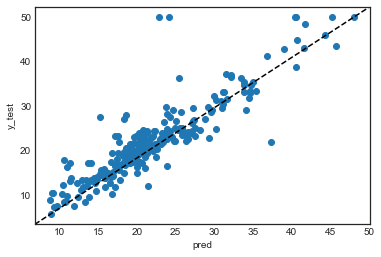

In [19]:
pred = regr1.predict(X_test)

plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

In [20]:
mean_squared_error(y_test, pred)

15.398432322134383

In [25]:
regr1.oob_score_

0.9019420915329107

In [21]:
# Random forests: using 10 features
regr2 = RandomForestRegressor(max_features=10, n_estimators =200, oob_score=True, random_state=1)
regr2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=True, random_state=1,
           verbose=0, warm_start=False)

In [22]:
pred = regr2.predict(X_test)
mean_squared_error(y_test, pred)

16.255935139328045

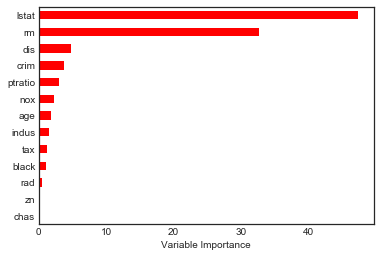

In [23]:
Importance = pd.DataFrame({'Importance':regr2.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

### Tasks: 
- how to pass categorical features to trees/forests ?
- fit a tree/forest to the Titanic data

### 8.3.4 Boosting

In [26]:
regr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, random_state=1)
regr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=1,
             subsample=1.0, verbose=0, warm_start=False)

zn          0.170382
rad         1.593909
chas        1.844703
indus       3.045285
nox         3.284683
tax         5.007437
black       5.082208
age         5.587239
crim        6.750284
ptratio     8.226473
dis        10.248698
rm         22.134290
lstat      27.024410
dtype: float64


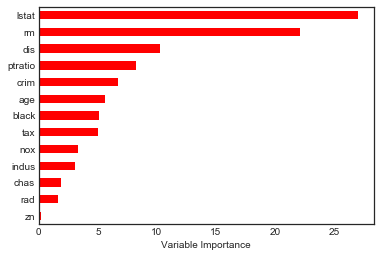

In [27]:
feature_importance = regr.feature_importances_*100
rel_imp = pd.Series(feature_importance, index=X.columns).sort_values(inplace=False)
print(rel_imp)
rel_imp.T.plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [28]:
mean_squared_error(y_test, regr.predict(X_test))

15.529710264059759